# 基本概念

## 构造原理

自动化机器学习AutoML是机器学习中一个相对较新的领域，它主要将机器学习中所有耗时过程自动化，如数据预处理、最佳算法选择、超参数调整等，这样可节约大量时间在建立机器学习模型过程中。

AutoML 通常涉及使用复杂的优化算法（例如贝叶斯优化）来有效地导航可能模型和模型配置的空间，并快速发现对给定预测建模任务最有效的方法。它允许非专家机器学习从业者快速轻松地发现对于给定数据集有效甚至最佳的方法，而技术背景或直接输入很少。

使用过 sklearn 的话，对于上面定义应该不难理解。下面再结合一个流程图来进一步理解一下。

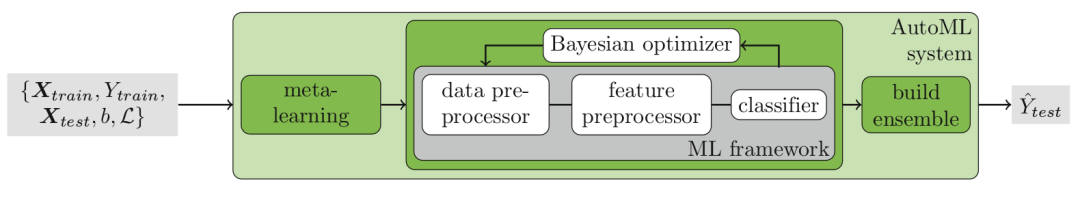

自动机器学习框架采用贝叶斯超参数优化方法，有效地发现给定数据集的性能最佳的模型管道。

这里另外添加了两个组件：

- 一个用于初始化贝叶斯优化器的元学习（meta-learning）方法
- 优化过程中的自动集成（automated ensemble）方法

这种元学习方法是贝叶斯优化的补充，用于优化 ML 框架。对于像整个 ML 框架一样大的超参数空间，贝叶斯优化的启动速度很慢。通过基于元学习选择若干个配置来用于种子贝叶斯优化。这种通过元学习的方法可以称为热启动优化方法。再配合多个模型的自动集成方法，使得整个机器学习流程高度自动化，将大大节省用户的时间。从这个流程来看，让机器学习使用者可以有更多的时间来选择数据以及思考要处理的问题本身。

## 贝叶斯优化

贝叶斯优化的原理是利用现有的样本在优化目标函数中的表现，构建一个后验模型。该后验模型上的每一个点都是一个高斯分布，即有均值和方差。若该点是已有样本点，则均值就是该点的优化目标函数取值，方差为0。而其他未知样本点的均值和方差是后验概率拟合的，不一定接近真实值。那么就用一个采集函数，不断试探这些未知样本点对应的优化目标函数值，不断更新后验概率的模型。由于采集函数可以兼顾Explore/Exploit，所以会更多地选择表现好的点和潜力大的点。因此，在资源预算耗尽时，往往能够得到不错的优化结果。即找到局部最优的优化目标函数中的参数。

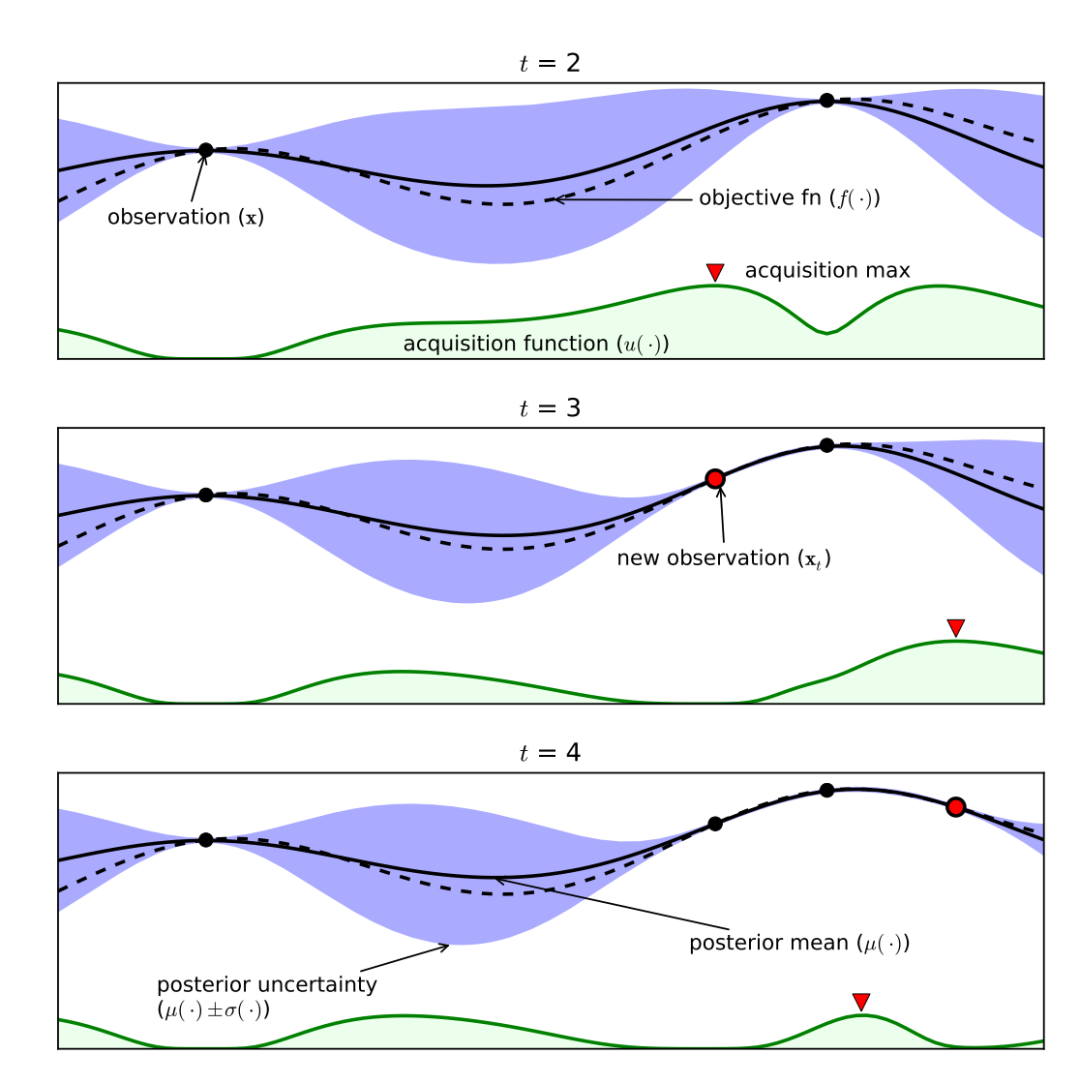

上图是在一个简单的 1D 问题上应用贝叶斯优化的实验图，这些图显示了在经过四次迭代后，高斯过程对目标函数的近似。我们以 t=3 为例分别介绍一下图中各个部分的作用。

上图 2 个 evaluations 黑点和一个红色 evaluations，是三次评估后显示替代模型的初始值估计，会影响下一个点的选择，穿过这三个点的曲线可以画出非常多条。黑色虚线曲线是实际真正的目标函数 （通常未知）。黑色实线曲线是代理模型的目标函数的均值。紫色区域是代理模型的目标函数的方差。绿色阴影部分指的是acquisition function的值，选取最大值的点作为下一个采样点。只有三个点，拟合的效果稍差，黑点越多，黑色实线和黑色虚线之间的区域就越小，误差越小，代理模型越接近真实模型的目标函数。

**算法的核心由两部分构成：对目标函数进行建模即计算每一点处的函数值的均值和方差，通常用高斯过程回归实现；构造采集函数，用于决定本次迭代时在哪个点处进行采样。**

# 代码实现

## auto-sklearn库

Auto-sklearn 提供了开箱即用的监督型自动机器学习。从名字可以看出，auto-sklearn 是基于机器学习库 scikit-learn 构建的，可为新的数据集自动搜索学习算法，并优化其超参数。因此，它将机器学习使用者从繁琐的任务中解放出来，使其有更多时间专注于实际问题。

目前仅支持linux版本，不支持Windows版本。

## 本地实现

### AutoSklearnClassifier

通过组合各种模型参数，利用贝叶斯优化进行参数寻优。[评估指标scoring列表](https://scikit-learn.org.cn/view/93.html#3.3.1%20%E8%AF%84%E5%88%86%E5%8F%82%E6%95%B0%EF%BC%9A%E5%AE%9A%E4%B9%89%E6%A8%A1%E5%9E%8B%E8%AF%84%E4%BC%B0%E5%87%86%E5%88%99)

In [296]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier  # 决策树
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score

In [297]:
#读取数据
data = pd.read_csv("../data/iris.csv")
print(data.head())

   Sepal.Length  Sepal.Width  Petal.Length  Petal.Width Species
0           5.1          3.5           1.4          0.2  setosa
1           4.9          3.0           1.4          0.2  setosa
2           4.7          3.2           1.3          0.2  setosa
3           4.6          3.1           1.5          0.2  setosa
4           5.0          3.6           1.4          0.2  setosa


In [298]:
#准备数据
data = data.dropna()
y = data['Species'].apply(lambda x: 1 if x == 'setosa' else 2 if x == 'versicolor' else 3)
x = data.drop(['Species'],axis=1).astype('float64')

# 训练集、测试集划分
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state= 42)

In [299]:
# 自动机器学习分类器
class AutoSklearnClassifier():
    def __init__(self, cv: int, n_jobs: int, n_iter: int, scoring: str):
        super(AutoSklearnClassifier, self).__init__()
        self.cv = cv  # 交叉验证折数
        self.n_jobs = n_jobs  # 允许使用的CPU数量
        self.n_iter = n_iter  # 迭代次数
        self.scoring = scoring # 评估指标

    # 模型训练
    def fit(self, x, y):
        self.x = x
        self.y = y
        # 定义模型和参数对应的字典
        total_optimizer = {}
        total_result = {}

        # 随机森林
        def __rf_cv(n_estimators,
                    min_samples_split,
                    max_features,
                    max_depth,
                    n_jobs=self.n_jobs,
                    scoring=self.scoring,
                    cv=self.cv,
                    x=x,
                    y=y):
            val = cross_val_score(
                RandomForestClassifier(
                    n_estimators=int(n_estimators),
                    min_samples_split=min(min_samples_split, 0.999),
                    max_features=int(max_features), 
                    max_depth=int(max_depth),
                    random_state=2),
                x,
                y,
                n_jobs=n_jobs,
                scoring=scoring,
                cv=cv).mean()
            return val

        rf_optimizer = BayesianOptimization(
            __rf_cv, {
                'n_estimators': (10, 250),
                'min_samples_split': (0.1, 0.999),
                'max_features': (2, 25),
                'max_depth': (5, 15),
            })
        print('---------------RandomForestClassifier---------------')
        rf_optimizer.maximize(init_points=5, n_iter=self.n_iter)
        rf_optimizer.set_gp_params(normalize_y=True)
        total_optimizer['RandomForestClassifier'] = rf_optimizer.max
        total_result['RandomForestClassifier'] = rf_optimizer.max['target']

        # 决策树
        def __dt_cv(min_samples_split,
                    max_features,
                    max_depth,
                    cv=self.cv,
                    n_jobs=self.n_jobs,
                    scoring=self.scoring,
                    x=x,
                    y=y):
            val = cross_val_score(
                DecisionTreeClassifier(
                    min_samples_split=min(min_samples_split, 0.999),
                    max_features=int(max_features),  
                    max_depth=int(max_depth),
                    random_state=2),
                x,
                y,
                n_jobs=n_jobs,
                scoring=scoring,
                cv=cv).mean()
            return val

        dt_optimizer = BayesianOptimization(
            __dt_cv, {
                'min_samples_split': (0.1, 0.999),
                'max_features': (2, 25),
                'max_depth': (5, 15),
            })
        print('---------------DecisionTreeClassifier---------------')
        dt_optimizer.maximize(init_points=5, n_iter=self.n_iter)
        dt_optimizer.set_gp_params(normalize_y=True)
        total_optimizer['DecisionTreeClassifier'] = dt_optimizer.max
        total_result['DecisionTreeClassifier'] = dt_optimizer.max['target']

        # 结果汇总
        best_classifier = sorted(total_result.items(),
                                 key=lambda x: x[1],
                                 reverse=True)[0][0]
        total_optimizer[best_classifier]['best_classifier'] = best_classifier

        # 设置字典输出
        self._best_classifier = {'best_classifier': best_classifier}
        self._outputs = {'sprint_statistics': total_optimizer}

    # 打印最佳训练结果
    def sprint_statistics(self):
        return self._outputs['sprint_statistics'][
            self._best_classifier['best_classifier']]['target']

    # 打印所有训练好的模型参数
    def show_models(self):
        return self._outputs['sprint_statistics']

    # 模型预测
    def predict(self, x):
        best_model = self._best_classifier['best_classifier']
        best_params = self._outputs['sprint_statistics'][
            self._best_classifier['best_classifier']]
        # 决策树
        if best_model == 'DecisionTreeClassifier':
            model = DecisionTreeClassifier(
                min_samples_split=best_params['params']['min_samples_split'],
                max_features=int(best_params['params']['max_features']),
                max_depth=int(best_params['params']['max_depth']),
            )
            model.fit(self.x, self.y)

        # 随机森林
        if best_model == 'RandomForestClassifier':
            model = RandomForestClassifier(
                max_depth=int(best_params['params']['max_depth']),
                min_samples_split=best_params['params']['min_samples_split'],
                max_features=int(best_params['params']['max_features']),
                n_estimators=int(best_params['params']['n_estimators']),
            )
            model.fit(self.x, self.y)
        return model.predict(x)

In [300]:
model = AutoSklearnClassifier(cv=5, n_jobs=8, n_iter=30, scoring='accuracy')

In [301]:
model.fit(x_train, y_train)

---------------RandomForestClassifier---------------
|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.919     | 7.323     | 14.26     | 0.3538    | 229.5     |
| 2         | 0.919     | 7.156     | 10.4      | 0.2968    | 231.4     |
| 3         | 0.9281    | 9.322     | 21.91     | 0.3099    | 16.2      |
| 4         | 0.3664    | 11.09     | 8.236     | 0.7036    | 85.68     |
| 5         | 0.9281    | 9.818     | 2.063     | 0.2657    | 98.07     |
| 6         | 0.9372    | 8.703     | 2.0       | 0.1       | 109.2     |
| 7         | 0.9277    | 14.56     | 8.588     | 0.3589    | 10.55     |
| 8         | 0.9368    | 14.77     | 10.9      | 0.5159    | 26.3      |
| 9         | 0.9549    | 5.0       | 22.27     | 0.1       | 32.74     |
| 10        | 0.9458    | 5.789     | 8.804     | 0.2236    | 41.7      |
| 11        | 0.33      | 15.0      | 21.59     | 0.999    

| 35        | 0.9281    | 10.16     | 18.04     | 0.1       |


In [302]:
model.sprint_statistics()

0.9549407114624506

In [303]:
model.show_models()

{'RandomForestClassifier': {'target': 0.9549407114624506,
  'params': {'max_depth': 5.0,
   'max_features': 22.267380358844967,
   'min_samples_split': 0.1,
   'n_estimators': 32.735930564656016},
  'best_classifier': 'RandomForestClassifier'},
 'DecisionTreeClassifier': {'target': 0.9367588932806324,
  'params': {'max_depth': 14.483026176559454,
   'max_features': 8.32233334487044,
   'min_samples_split': 0.3745041180403512}}}

In [304]:
prediction = model.predict(x_test)

In [305]:
# 计算准确率
acc = accuracy_score(y_test, prediction)
print("acc为：", acc)

acc为： 1.0


### AutoSklearnRegressor

In [279]:
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_score
from bayes_opt import BayesianOptimization
from bayes_opt.util import UtilityFunction
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import math
from sklearn.metrics import accuracy_score

In [280]:
#读取数据
data = pd.read_csv("../data/boston_housing_data.csv")
print(data.head())

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900    1  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671    2  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671    2  242.0   
3  0.03237   0.0   2.18   0.0  0.458  6.998  45.8  6.0622    3  222.0   
4  0.06905   0.0   2.18   0.0  0.458  7.147  54.2  6.0622    3  222.0   

   PIRATIO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  
3     18.7  394.63   2.94  33.4  
4     18.7  396.90   5.33  36.2  


In [281]:
#准备数据
data = data.dropna()
y = data['MEDV']
x = data.drop(['MEDV'],axis=1).astype('float64')

# 训练集、测试集划分
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.25,random_state= 42)

In [282]:
# 自动机器学习分类器
class AutoSklearnRegressor():
    def __init__(self, cv: int, n_jobs: int, n_iter: int, scoring: str):
        super(AutoSklearnRegressor, self).__init__()
        self.cv = cv  # 交叉验证折数
        self.n_jobs = n_jobs  # 允许使用的CPU数量
        self.n_iter = n_iter  # 迭代次数
        self.scoring = scoring # 评估指标

    # 模型训练
    def fit(self, x, y):
        self.x = x
        self.y = y
        # 定义模型和参数对应的字典
        total_optimizer = {}
        total_result = {}

        # 随机森林
        def __rf_cv(n_estimators,
                    min_samples_split,
                    max_features,
                    max_depth,
                    n_jobs=self.n_jobs,
                    scoring=self.scoring,
                    cv=self.cv,
                    x=x,
                    y=y):
            val = cross_val_score(
                RandomForestRegressor(
                    n_estimators=int(n_estimators),
                    min_samples_split=min(min_samples_split, 0.999),
                    max_features=int(max_features), 
                    max_depth=int(max_depth),
                    random_state=2),
                x,
                y,
                n_jobs=n_jobs,
                scoring=scoring,
                cv=cv).mean()
            return val

        rf_optimizer = BayesianOptimization(
            __rf_cv, {
                'n_estimators': (10, 250),
                'min_samples_split': (0.1, 0.999),
                'max_features': (2, 25),
                'max_depth': (5, 15),
            })
        print('---------------RandomForestRegressor---------------')
        rf_optimizer.maximize(n_iter=self.n_iter)
        rf_optimizer.set_gp_params(normalize_y=True)
        total_optimizer['RandomForestRegressor'] = rf_optimizer.max
        total_result['RandomForestRegressor'] = rf_optimizer.max['target']

        # 决策树
        def __dt_cv(min_samples_split,
                    max_features,
                    max_depth,
                    cv=self.cv,
                    n_jobs=self.n_jobs,
                    scoring=self.scoring,
                    x=x,
                    y=y):
            val = cross_val_score(
                DecisionTreeRegressor(
                    min_samples_split=min(min_samples_split, 0.999),
                    max_features=int(max_features),  
                    max_depth=int(max_depth),
                    random_state=2),
                x,
                y,
                n_jobs=n_jobs,
                scoring=scoring,
                cv=cv).mean()
            return val

        dt_optimizer = BayesianOptimization(
            __dt_cv, {
                'min_samples_split': (0.1, 0.999),
                'max_features': (2, 25),
                'max_depth': (5, 15),
            })
        print('---------------DecisionTreeRegressor---------------')
        dt_optimizer.maximize(n_iter=self.n_iter)
        dt_optimizer.set_gp_params(normalize_y=True)
        total_optimizer['DecisionTreeRegressor'] = dt_optimizer.max
        total_result['DecisionTreeRegressor'] = dt_optimizer.max['target']

        # 结果汇总
        best_regressor = sorted(total_result.items(),
                                 key=lambda x: x[1],
                                 reverse=True)[0][0]
        total_optimizer[best_regressor]['best_regressor'] = best_regressor

        # 设置字典输出
        self._best_regressor = {'best_regressor': best_regressor}
        self._outputs = {'sprint_statistics': total_optimizer}

    # 打印最佳训练结果
    def sprint_statistics(self):
        return self._outputs['sprint_statistics'][
            self._best_regressor['best_regressor']]['target']

    # 打印所有训练好的模型参数
    def show_models(self):
        return self._outputs['sprint_statistics']

    # 模型预测
    def predict(self, x):
        best_model = self._best_regressor['best_regressor']
        best_params = self._outputs['sprint_statistics'][
            self._best_regressor['best_regressor']]
        # 决策树
        if best_model == 'DecisionTreeRegressor':
            model = DecisionTreeRegressor(
                min_samples_split=best_params['params']['min_samples_split'],
                max_features=int(best_params['params']['max_features']),
                max_depth=int(best_params['params']['max_depth']),
            )
            model.fit(self.x, self.y)

        # 随机森林
        if best_model == 'RandomForestRegressor':
            model = RandomForestRegressor(
                max_depth=int(best_params['params']['max_depth']),
                min_samples_split=best_params['params']['min_samples_split'],
                max_features=int(best_params['params']['max_features']),
                n_estimators=int(best_params['params']['n_estimators']),
            )
            model.fit(self.x, self.y)
        return model.predict(x)

In [285]:
model = AutoSklearnRegressor(cv=5, n_jobs=8, n_iter=30, scoring='r2')

In [286]:
model.fit(x_train, y_train)

---------------RandomForestRegressor---------------
|   iter    |  target   | max_depth | max_fe... | min_sa... | n_esti... |
-------------------------------------------------------------------------
| 1         | 0.507     | 14.45     | 2.085     | 0.3854    | 148.0     |
| 2         | -0.0118   | 7.025     | 17.32     | 0.8787    | 85.72     |
| 3         | 0.7195    | 10.68     | 10.53     | 0.2367    | 42.13     |
| 4         | -0.01145  | 7.35      | 9.732     | 0.8874    | 214.7     |
| 5         | 0.7781    | 10.66     | 13.51     | 0.1099    | 60.22     |
| 6         | 0.7832    | 15.0      | 24.93     | 0.1       | 50.32     |
| 7         | 0.701     | 9.646     | 13.55     | 0.2883    | 61.35     |
| 8         | 0.6884    | 15.0      | 2.0       | 0.1       | 54.47     |
| 9         | 0.78      | 15.0      | 25.0      | 0.1       | 21.46     |
| 10        | 0.7851    | 5.0       | 11.11     | 0.1       | 10.0      |
| 11        | 0.4957    | 14.81     | 2.451     | 0.4871    

| 35        | 0.7733    | 14.87     | 21.74     | 0.1372    |


In [287]:
model.sprint_statistics()

0.7967862644521461

In [288]:
model.show_models()

{'RandomForestRegressor': {'target': 0.7967862644521461,
  'params': {'max_depth': 13.564994978344325,
   'max_features': 10.217679597341117,
   'min_samples_split': 0.1,
   'n_estimators': 55.32226912617524},
  'best_regressor': 'RandomForestRegressor'},
 'DecisionTreeRegressor': {'target': 0.7802626160860318,
  'params': {'max_depth': 14.465705027540277,
   'max_features': 13.040506956527723,
   'min_samples_split': 0.1143395744766569}}}

In [289]:
prediction = model.predict(x_test)

In [291]:
# 计算R2，均方差
r2 = r2_score(y_test, prediction)
mse = np.sqrt(mean_squared_error(y_test, prediction))

In [292]:
print("R2为：", r2)
print("MSE为：", mse)

R2为： 0.8515597593502202
MSE为： 3.1109855966503197
